In [20]:
!pip install pygame

You should consider upgrading via the 'c:\users\admin\appdata\local\programs\python\python38\python.exe -m pip install --upgrade pip' command.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qugames import snake

pygame 2.1.0 (SDL 2.0.16, Python 3.8.10)
Hello from the pygame community. https://www.pygame.org/contribute.html


(128, 128, 3)
5 0 4
(128, 128, 3)


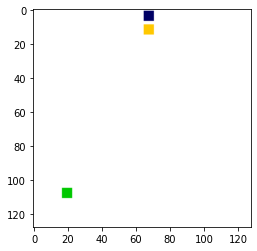

0 0


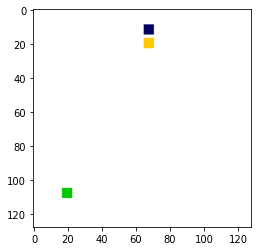

[[[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 ...

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]

 [[255 255 255]
  [255 255 255]
  [255 255 255]
  ...
  [255 255 255]
  [255 255 255]
  [255 255 255]]]


In [2]:
env = snake.Snake()
print(env.observation_space.shape)
print(env.action_space.n, env.action_space.low, env.action_space.high)

s = env.reset()
print(s.shape)

plt.imshow(s)
plt.show()

s, r, done, _ = env.step(0)
print(r, done)
plt.imshow(s)
plt.show()

print(s)

In [4]:
def policy(s):
    return env.action_space.sample()
    
def run_episode(ticks=1000):    
    rew = 0
    s = env.reset()
    for t in range(1, ticks+1):
        a = policy(s)
        s, r, done, _ = env.step(a)       
        rew += r
        if done:
            break
    return rew, t
        
rews, lens = [], []
for _ in range(1000):
    r,l = run_episode()    
    rews.append(r)
    lens.append(l)

print(f"{np.mean(rews):.0f} ± {np.std(rews):.0f}  ({np.min(rews)}, {np.max(rews)})")
print(f"{np.mean(lens):.0f} ± {np.std(lens):.0f}  ({np.min(lens)}, {np.max(lens)})")


-100 ± 1  (-100, -90)
4 ± 4  (1, 22)


In [3]:
import torch
import torch.nn as nn

#========================================================================================

class AgentModel(nn.Module):
    """ Neural network for Q(s,a) """
    def __init__(self, state_shape, nA = 5, 
                 channels=[12,24,64], kernels = [8,3,3], strides = [8,1,1], paddings = [0,1,1],
                 pools=[2,2,2], dropout=0.2,  hidden = 128):
        """
        state_shape = (3 * n_frames, image_width, image_height)
        nA - number of state (Snake = 5)
        """
        super(AgentModel, self).__init__()
                
        channels = [ state_shape[0] ] + channels;  conv_kernels = kernels      
        w, h     =  state_shape[1], state_shape[2]
        layers = []
        for i in range(len(channels)-1):
            layers +=  [ 
                nn.Conv2d(channels[i], channels[i+1], kernel_size=kernels[i], stride=strides[i], padding=paddings[i]),
                nn.ReLU()]
            if pools[i] > 1:
                layers += [
                    nn.MaxPool2d(kernel_size=pools[i], stride=pools[i]),
                    nn.Dropout(p=dropout) ]                            
            w = (((w + 2*paddings[i] - kernels[i]) // strides[i] + 1) - pools[i]) // pools[i] + 1
            h = (((h + 2*paddings[i] - kernels[i]) // strides[i] + 1) - pools[i]) // pools[i] + 1        
            
        self.features = channels[-1] * w * h
        layers += [ 
            nn.Flatten(1),
            nn.Linear(self.features, hidden),
            nn.ReLU(),
            nn.Linear(hidden, nA) ]                
                
        self.model = nn.Sequential(*layers)       
 
    def forward(self, x):        
        return self.model(x)        

    
config = {
            'channels' : [2,48,92],       # conv channles
            'kernels'  : [8,3,3],         # conv kernels
            'strides'  : [8,1,1],         # conv strides
            'paddings' : [0,1,1],         # conv paddings
            'pools'    : [1,2,2],         # = pool_strides
            'dropout'  : 0.2,             # after cnn,reLU,pool 
            'hidden'   : 256,             # hidden layers                
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")    
state_shape = (6,128,128)
model = AgentModel(state_shape, 5,
                  channels=config['channels'], kernels = config['kernels'], paddings = config['paddings'],
                  pools = config['pools'], dropout=config['dropout'], hidden  = config['hidden']).to(device)     


state = torch.load('models/best_e2_r130__Snake.pt') 

print((state['model']))
model.load_state_dict(state['state'])


def policy(state):
    state = torch.tensor(state)
    x = state.unsqueeze(dim=0).to(device)
    with torch.no_grad():
        y = model(x).detach().to('cpu').numpy() 
    return np.argmax(y)                     

AgentModel(
  (model): Sequential(
    (0): Conv2d(6, 2, kernel_size=(8, 8), stride=(8, 8))
    (1): ReLU()
    (2): Conv2d(2, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Dropout(p=0.2, inplace=False)
    (6): Conv2d(48, 92, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.2, inplace=False)
    (10): Flatten(start_dim=1, end_dim=-1)
    (11): Linear(in_features=1472, out_features=256, bias=True)
    (12): ReLU()
    (13): Linear(in_features=256, out_features=5, bias=True)
  )
)


In [12]:
from PIL import Image, ImageDraw, ImageFont
import imageio

def render_frame(frame, text: str):
    """
    Get frame with overwritten text:
    """
    #canvas = np.full((256,256,3), 128).astype(int)
    #canvas[0:128, 0:128] = frame[:,:]
    canvas = frame
    im = Image.fromarray(canvas, mode="RGB")
    if text:        
        drawer = ImageDraw.Draw(im)    
        text_color = (255,255,255) if np.mean(im) < 128 else (0,0,0)
        font = ImageFont.truetype("verdana.ttf", 8)
        drawer.text((0, 0), text, fill=text_color, font=font)             
        #font = ImageFont.truetype("verdana.ttf", 8)
        #drawer.text((im.size[0]-100,im.size[1]-20), "QuData.com", fill=(0,255,0), font=font)
    return im

def set_state(s1,s2):
    s1 = torch.tensor(s1, dtype=torch.float32).permute(2, 0, 1)/255.
    s2 = torch.tensor(s2, dtype=torch.float32).permute(2, 0, 1)/255.
    return torch.cat([s1,s2],0)


frames, last = [], 0
for episode in range(1, 11):
    rew, wait = 0, 0    
    
    oi = env.reset()                    # initial state        
    o0, _, _, _ = env.step(0)           # nothing do
    s0 = set_state(oi,o0)
    a0 = policy(s0)                     # get action            
    
    for t in range(1, 1001):       
        o1, r1, done, _ = env.step(a0)            
        s1 = set_state(o0,o1)
        a1 = policy(s1)        
        rew += r1            
        
        frame = render_frame(o1, f"{episode:2d}:{t:3d}({rew})")
        frames.append(frame)
        if episode == 1 and t == 1:
            print(frame.width)
        
    
        if done:  
            for i in range(5):
                frames.append(frame)
            break       
            
        s0, a0, o0 = s1, a1, o1

imageio.mimwrite("render.mp4", frames, fps=10)            
env.close()
print("done")

C:\Users\Admin\AppData\Local\Temp\ipykernel_2692\1377307983.py:67: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state = torch.tensor(state)


128
done


In [13]:
(10000/100)**0.5

10.0